## Forecasting using time series models

In this notebook we try to predict the weekly sales for the last 8 weeks using time series techniques.

##### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import warnings
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

sns.set_palette("Set2")
%matplotlib inline
warnings.filterwarnings('ignore')

##### Definition of Helper Functions

In [2]:
def error_table(model_name, y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mape = mean_absolute_percentage_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [model_name])

##### Read data

In [3]:
y_train = pd.read_csv("../data/y_train.csv", parse_dates=['Date'], index_col=['Store', 'Date'])
y_test = pd.read_csv("../data/y_test.csv", parse_dates=['Date'], index_col=['Store', 'Date'])
display(y_train)

Sales
Store Date                 
1     2015-06-01  10.122543
      2015-05-25  10.255130
      2015-05-18  10.019536
      2015-05-11   9.972780
      2015-05-04  10.212185
...                     ...
1115  2013-01-28  10.260707
      2013-01-21  10.302532
      2013-01-14  10.036663
      2013-01-07  10.229079
      2012-12-31  10.094562

[136726 rows x 1 columns]

##### Fill missing obervations in train data set with store mean 

In [4]:
# first recover the sales at their original scale
y_train['Sales'] = np.expm1(y_train['Sales'])

In [5]:
# get stores which have mising observations
by_store = y_train.groupby('Store')
obs = by_store.count().rename({'Sales' : 'Observations'}, axis = 1)
max_obs = obs['Observations'].max()

missing_stores = obs[obs['Observations'] < max_obs].index

In [6]:
# fill missing observations with nans
stores = y_train.index.get_level_values(0).unique().sort_values()
dates = y_train.index.get_level_values(1).unique().sort_values()
full_index = pd.MultiIndex.from_product([stores, dates])
y_train = y_train.reindex(full_index)
y_train.isnull().sum()

Sales    4879
dtype: int64

In [7]:
# fill missing observations with store means
avgs = y_train.groupby('Store').mean().rename({'Sales' : 'AvgSales'}, axis = 1)
y_train = y_train.join(avgs)
y_train['Sales'] = y_train['Sales'].fillna(y_train['AvgSales'])
y_train.isnull().sum()

Sales       0
AvgSales    0
dtype: int64

##### Explore time series characteristics at a global level:

Concatenate y_train and y_test vertically to the the analysis with the hole data

In [ ]:
global_y_train = y_train.reset_index()
global_y_train.set_index('Date', inplace=True)
# first recover the sales at their original scale
global_y_train['Sales'] = np.expm1(global_y_train['Sales'])
# aggregate all the stores for each date and log scale once again
global_y_train = global_y_train.groupby('Date').sum()#.drop('Store', axis=1)
global_y_train['Sales'] = np.log1p(global_y_train['Sales'])

In [ ]:
fig, ax = plt.subplots()

ax.plot(global_y_train.index, global_y_train['Sales'])
ax.set_xlabel('Date')
ax.set_ylabel('Sales')


fig.autofmt_xdate()
fig.suptitle('Time series for global sales')
plt.tight_layout();

# Plot trend and seasonal for different periods

In [6]:
# I'll take period=8 because we want to predit the last 8 weeks
global_decomposition = STL(global_y_train['Sales'], period=4).fit()

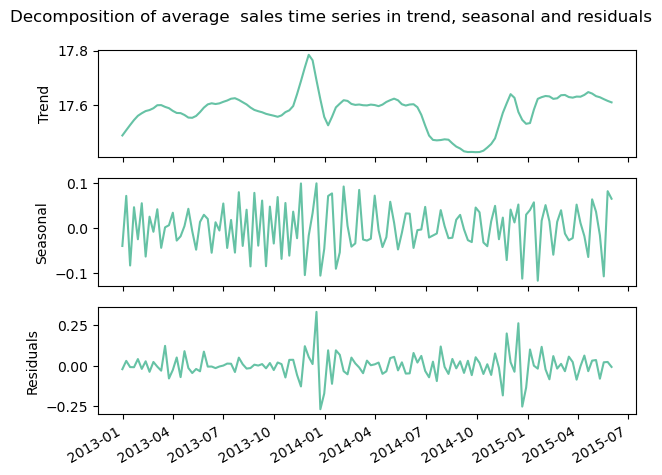

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True)

ax1.plot(global_decomposition.trend)
ax1.set_ylabel('Trend')

ax2.plot(global_decomposition.seasonal)
ax2.set_ylabel('Seasonal')

ax3.plot(global_decomposition.resid)
ax3.set_ylabel('Residuals')

fig.autofmt_xdate()
fig.suptitle('Decomposition of average  sales time series in trend, seasonal and residuals')
plt.tight_layout();

We run the augmented Dickey-Fuller test to check if we are dealing with a sationary process:

In [8]:
ADF_result = adfuller(global_y_train['Sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -9.658632687762946
p-value: 1.372441936289322e-16


We have a large negative ADF value and a very small p-value, which reinforces the visual intuition that we are dealing with a more or less stationary process.

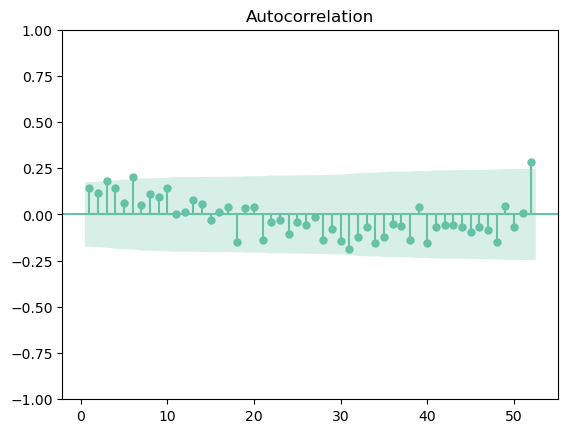

In [9]:
plot_acf(global_y_train['Sales'], zero=False, lags=52);

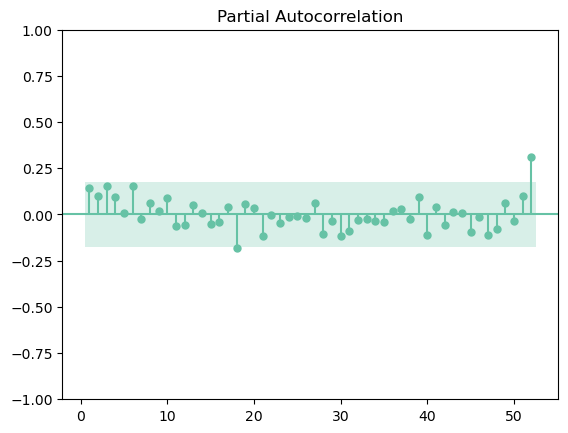

In [10]:
plot_pacf(global_y_train['Sales'], zero=False, lags=52);

Sales    4879
dtype: int64

Take differences to stabilize the mean?

##### Autoregressive Model AR(p)

Plot an autocorrelation plot for the train data at a global level (all the stores), to decide which lag(s) to include in the model:

In [8]:
# Get 1 store
#foo = y_train[np.in1d(y_train.index.get_level_values(0), 1)]
#plot_acf(foo);

In [9]:
global_train = y_train.reset_index()
global_train.set_index('Date', inplace=True)
# first recover the sales at their original scale
global_train['Sales'] = np.expm1(global_train['Sales'])
# aggregate all the stores for each date and log scale once again
global_train = global_train.groupby('Date').sum().drop('Store', axis=1)
global_train['Sales'] = np.log1p(global_train['Sales'])

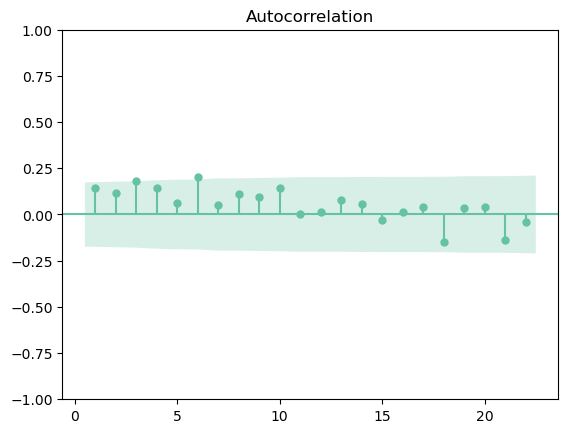

In [10]:
plot_acf(global_train, zero=False);

As we can observe, the autocorrelations for the third and sixth lag lie outisde the shaded area. Therefore we will train an autoregressive model with lags 3 and 6 for each store.

In [23]:
# revert to single index on date
y_train_1 = y_train.reset_index(level=[0])
y_test_1 = y_test.reset_index(level=[0])

y_ar_test_list = []
y_ar_pred_list = []

# loop over stores
for s in np.sort(y_train_1['Store'].unique()):
#for s in [1]:
    y_test_s = y_test_1[y_test_1['Store'] == s]['Sales']
    y_train_s = y_train_1[y_train_1['Store'] == s]['Sales']
    # Is good to have also the store as part of the index
    y_test_s.index = pd.MultiIndex.from_tuples([(s, date) for date in y_test_s.index], names=('Store', 'Date'))
    # fit and predict
    ar_model = AutoReg(y_train_s, lags=[3,6,52])
    ar_results = ar_model.fit()
    y_pred_s = ar_results.predict(start=len(y_train_s), end=len(y_train_s) + len(y_test_s) - 1, dynamic=False)
    y_pred_s.index = y_test_s.index
    # append to lists
    y_ar_test_list.append(y_test_s)
    y_ar_pred_list.append(y_pred_s)

# concatenate series
y_ar_test = pd.concat(y_ar_test_list)
y_ar_pred = pd.concat(y_ar_pred_list)

In [12]:
error_table('AR(3,6)', np.expm1(y_ar_test), np.expm1(y_ar_pred))

,Model Name,MAE,MAPE,RMSE
"AR(3,6)","AR(3,6)",4977.274593,0.125097,7163.405489


In [15]:
y_train_s

Date
2015-06-01    10.663241
2015-05-25    10.712661
2015-05-18    10.543419
2015-05-11    10.527204
2015-05-04    10.668374
                ...    
2013-01-28    10.260707
2013-01-21    10.302532
2013-01-14    10.036663
2013-01-07    10.229079
2012-12-31    10.094562
Name: Sales, Length: 127, dtype: float64

In [6]:
#Toy example
#y_train_0 = y_train[0]['Sales']
#y_test_0 = y_test[0]['Sales']

#ar_model = AutoReg(y_train_0, lags=[3,6])
#ar_results = ar_model.fit()
#y_pred_0 = ar_results.predict(start=len(y_train_0), end=len(y_train_0) + len(y_test_0) - 1, dynamic=False)

#error_table( 'AR(1)', np.expm1(y_test_0), np.expm1(y_pred_0))